In [13]:

import warnings
warnings.filterwarnings("ignore")

from scripts import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import log_loss
import optuna
from tqdm import tqdm

from lightgbm import LGBMClassifier

import pickle

# Read Dataset

In [2]:
train = pd.read_csv("../datasets/KDDTrain+.csv")
test = pd.read_csv("../datasets/KDDTest+.csv")
df = pd.concat([train, test], axis=0)

# Rename column
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'difficulty'
]

df.rename({f"Column{i+1}" : col for i,col in enumerate(columns)}, axis=1, inplace=True)

# Tipe fitur
categoric_features = [
    "protocol_type", "service", "flag", "land", "logged_in",
    "root_shell", "su_attempted", "is_host_login", "is_guest_login"
]
numeric_features = [
    'duration', 'src_bytes', 'dst_bytes','wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'num_compromised', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]
to_drop_features = ['difficulty']

# Drop kolom yang tidak relevan
df.drop(columns=to_drop_features, inplace=True)

# Mapping tipe serangan ke kategori
attack_mapping = {
    # Normal Traffic
    'normal': 'normal',

    # Denial of Service (DoS)
    'neptune': 'DoS',         # SYN Flood
    'back': 'DoS',            # Back Orifice (flood)
    'teardrop': 'DoS',        # Fragmentation Attack
    'smurf': 'DoS',           # ICMP Flood
    'pod': 'DoS',             # Ping of Death
    'land': 'DoS',            # LAND Attack
    'apache2': 'DoS',         # Apache HTTP DoS
    'processtable': 'DoS',    # Process Table Exhaustion
    'mailbomb': 'DoS',        # Email Spam Flood
    'udpstorm': 'DoS',        # UDP Flood
    'ps': 'DoS',              # Process Spawn Attack
    'xlock': 'DoS',           # Xlock Resource Exhaustion

    # Remote to Local (R2L) - Unauthorized Access
    'guess_passwd': 'R2L',    # Password Brute Force
    'ftp_write': 'R2L',       # FTP Write Exploit
    'imap': 'R2L',            # IMAP Exploit
    'phf': 'R2L',             # PHF CGI Exploit
    'multihop': 'R2L',        # Multi-hop Compromise
    'warezclient': 'R2L',     # Warez Client Activity
    'warezmaster': 'R2L',     # Warez Server Exploit
    'spy': 'R2L',             # Spyware Activity
    'snmpguess': 'R2L',       # SNMP Brute Force
    'snmpgetattack': 'R2L',   # SNMP Get Exploit
    'sendmail': 'R2L',        # Sendmail Vulnerability
    'xsnoop': 'R2L',          # X Window Snooping
    'sqlattack': 'R2L',       # SQL Injection

    # User to Root (U2R) - Privilege Escalation
    'buffer_overflow': 'U2R', # Classic BoF Exploit
    'rootkit': 'U2R',         # Rootkit Installation
    'loadmodule': 'U2R',      # Kernel Module Hijacking
    'perl': 'U2R',            # Perl Script Exploit
    'xterm': 'U2R',           # Xterm Escape Exploit
    'named': 'U2R',           # BIND DNS Exploit (Privilege Escalation)
    'worm': 'DoS',            # Worm sebagai DoS (karena traffic overload)

    # Probing (Scanning/Surveillance)
    'ipsweep': 'Probing',     # Network Scanning
    'portsweep': 'Probing',   # Port Scanning
    'nmap': 'Probing',        # Nmap Scanning
    'satan': 'Probing',       # SATAN Vulnerability Scanner
    'mscan': 'Probing',       # Massive Scanning
    'saint': 'Probing',       # SAINT Exploit Scanner
    'httptunnel': 'Probing',  # HTTP Tunneling untuk C2/Scanning
}
df['label'] = df['label'].map(attack_mapping)

print(f"Ukuran dataset : {df.shape}")
df.head()

Ukuran dataset : (148517, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Exploratory Data Analysis

## 1. Drop Duplicated

In [3]:
print(f"Ukuran dataset awal: {df.shape}")
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

# Drop duplikasi data
df.drop_duplicates(keep='first', inplace=True)

print(f"\nUkuran dataset akhir: {df.shape}")
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Ukuran dataset awal: (148517, 42)
Jumlah data duplikat: 629

Ukuran dataset akhir: (147888, 42)
Jumlah data duplikat: 0


## 2. Cek Missing Value

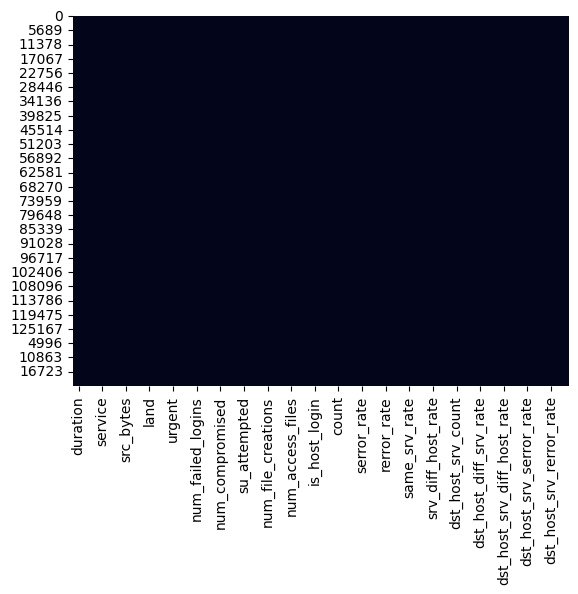

In [4]:
sns.heatmap(df.isnull(), cbar=False);

In [5]:
utils.cek_missing(df)

,Jumlah,Persentase
duration,0,0.0
protocol_type,0,0.0
service,0,0.0
flag,0,0.0
src_bytes,0,0.0
dst_bytes,0,0.0
land,0,0.0
wrong_fragment,0,0.0
urgent,0,0.0
hot,0,0.0


## 3. Cek Imbalance Dataset

In [6]:
print("Target proportion:")
df.label.value_counts(normalize=False)

Target proportion:


label
normal     76967
DoS        53011
Probing    14068
R2L         3723
U2R          119
Name: count, dtype: int64

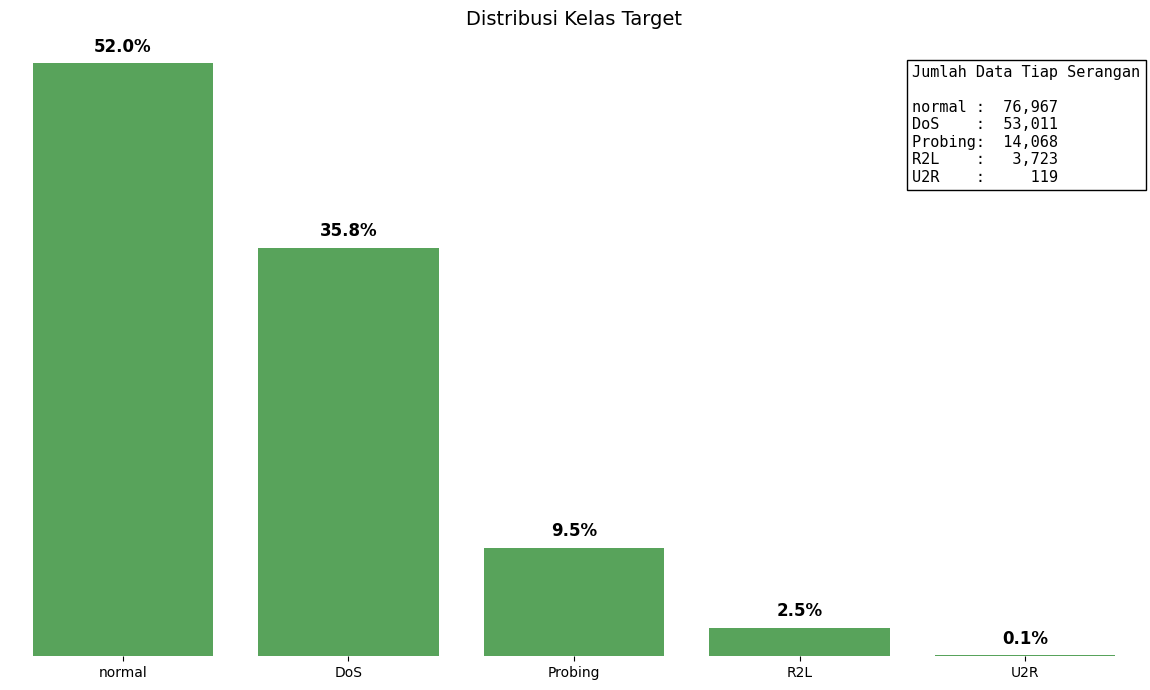

In [7]:
label_counts = df['label'].value_counts()
label_percent = (label_counts / label_counts.sum()) * 100

plt.figure(figsize=(12, 7))
bars = sns.barplot(x=label_counts.index, y=label_percent.values, color="#4CAF50")  # warna seragam

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', fontsize=12, weight='bold')

summary = "\n".join([f"{k:<7}: {v:>7,}" for k, v in label_counts.items()])
plt.text(x=3.5, y=max(label_percent)*0.8, s=f"Jumlah Data Tiap Serangan\n\n{summary}",
         bbox=dict(facecolor='white', edgecolor='black'), fontsize=11, family='monospace')

plt.gca().axes.get_yaxis().set_visible(False)
plt.box(False)
plt.title("Distribusi Kelas Target", fontsize=14)
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.show()

## 4. Distribusi Fitur Numerik

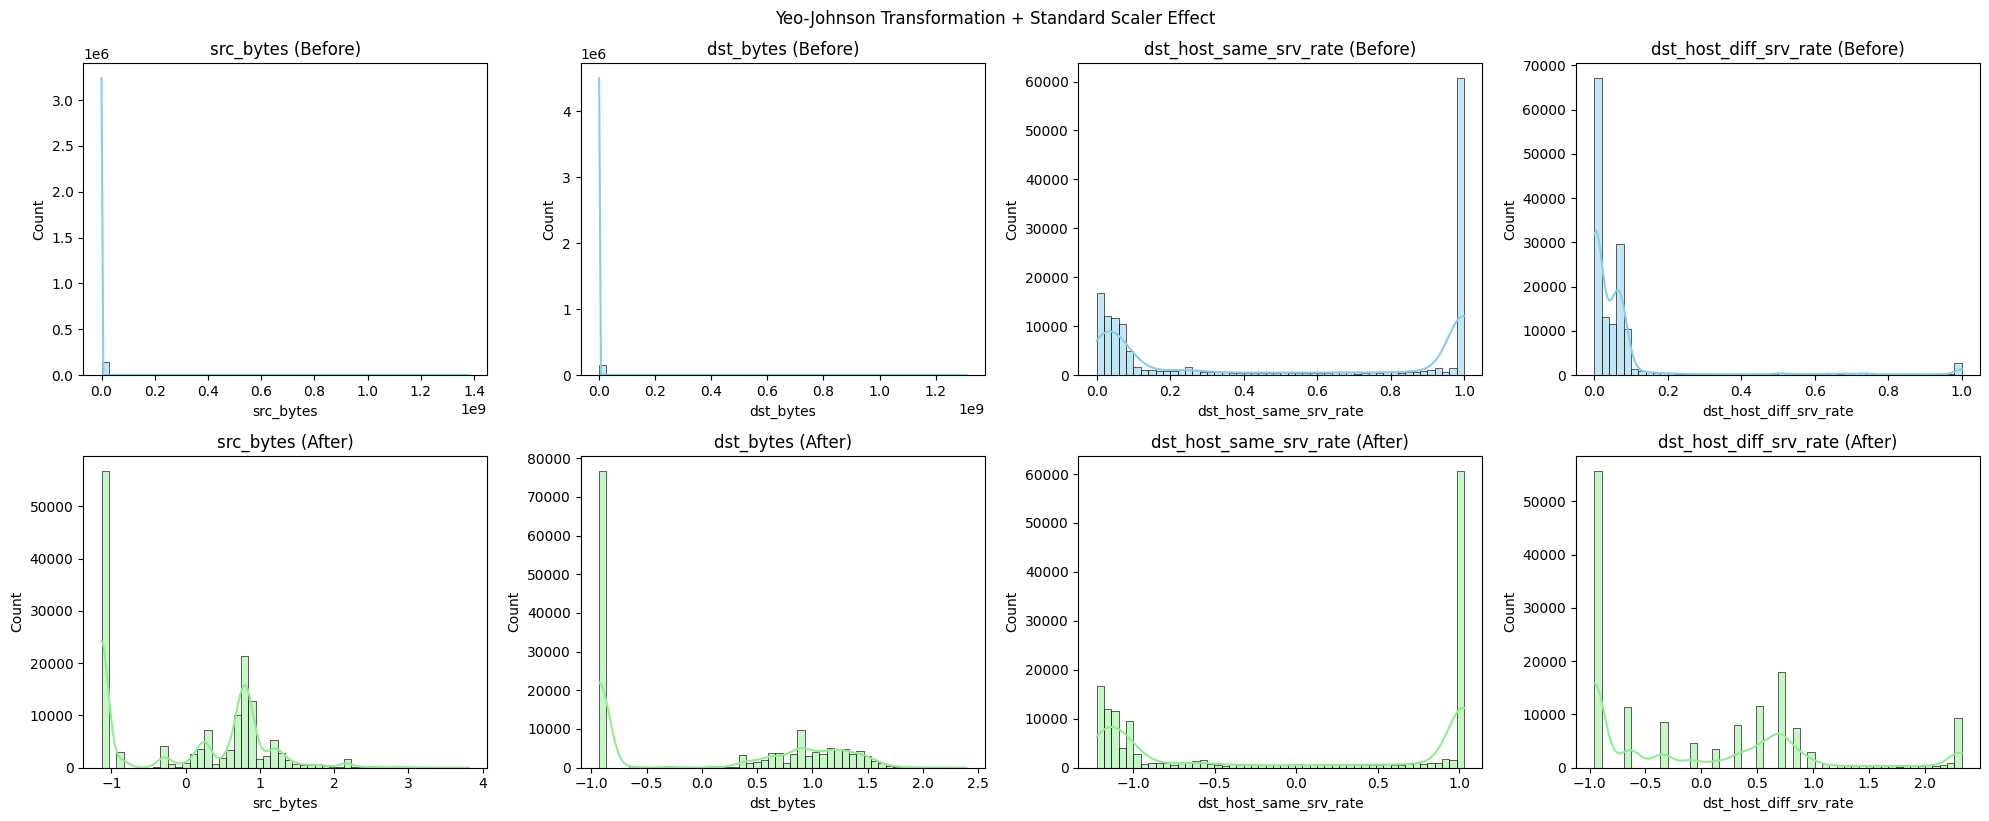

In [8]:
features = ['src_bytes', 'dst_bytes', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']
df_selected = df[features]

# Yeo-Johnson + Standard Scaler
pt = PowerTransformer(method='yeo-johnson')
scaled = StandardScaler().fit_transform(pt.fit_transform(df_selected))
df_transformed = pd.DataFrame(scaled, columns=features)

# Plot Before & After
fig, axes = plt.subplots(2, len(features), figsize=(20, 8))
for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, ax=axes[0, i], bins=50, color='skyblue')
    axes[0, i].set_title(f"{col} (Before)")
    
    sns.histplot(df_transformed[col], kde=True, ax=axes[1, i], bins=50, color='lightgreen')
    axes[1, i].set_title(f"{col} (After)")
    
plt.tight_layout()
plt.suptitle("Yeo-Johnson Transformation + Standard Scaler Effect", y=1.02)
plt.show()

## 5. Heatmap Correlation

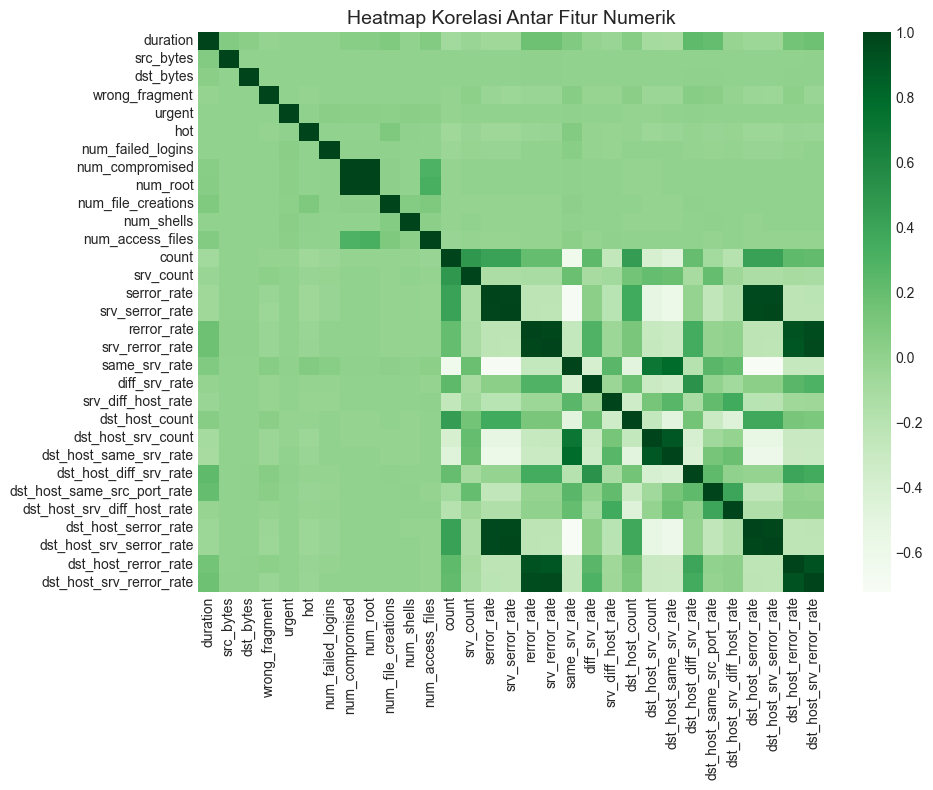

In [ ]:
numeric_features_no_outbound = [col for col in numeric_features if col != 'num_outbound_cmds']
corr_matrix = df[numeric_features_no_outbound].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="Greens", cbar=True)

plt.title("Heatmap Korelasi Antar Fitur Numerik", fontsize=14)
plt.tight_layout()
plt.show()

# Splitting Dataset

In [9]:
X = df.drop(columns=["label"])
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118310, 41), (29578, 41), (118310,), (29578,))

# Feature Engineering & Data Preprocessing

In [10]:
categoric_pipeline = Pipeline([
    ('encoder',utils.TargetFeatureEncoder(to_encode=categoric_features))
])

numeric_pipeline = Pipeline([
    ('yeojohnson', utils.YeoJohnsonTransformer(columns=numeric_features)),
    ('scaler', utils.StandardScalerTransformer(columns=numeric_features))
])

preprocessor = ColumnTransformer([
    ('categoric', categoric_pipeline, categoric_features),
    ('numeric', numeric_pipeline, numeric_features)
], verbose_feature_names_out=False)

In [11]:
# Encode label menjadi angka
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [12]:
# Compute sample weights untuk menangani ketidakseimbangan kelas
sample_weights = compute_sample_weight('balanced', y_train_enc)

# Feature Selection

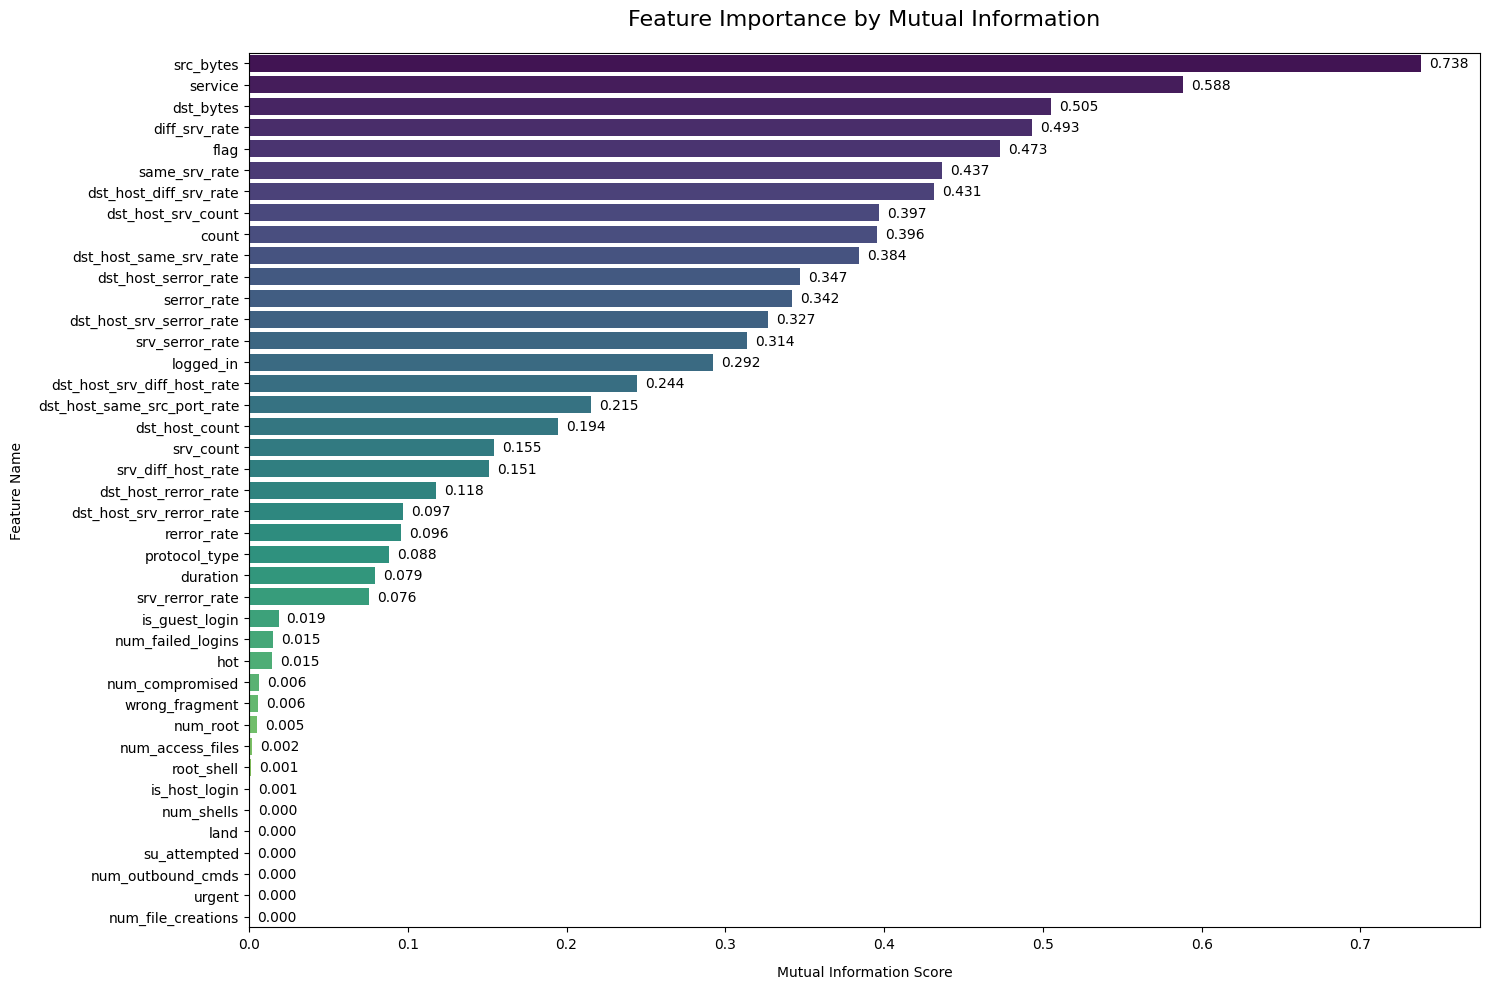

In [13]:
# Mutual Information
preprocessor.fit(X_train, y_train_enc)
mi_results = utils.plot_mutual_info_scores(preprocessor, X_train, y_train_enc)

# Model Training

In [14]:
# Training
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=NUM_CLASSES,
    metric='multi_logloss',
    verbose=0,
    random_state=42
)

feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('algo', utils.StratifiedKFoldMulticlass(
        estimator=lgbm_model,
        n_folds=3,
        method='predict_proba',
        random_state=42
    ))
])

pipeline.fit(
    X_train, 
    y_train_enc,
    algo__sample_weight=sample_weights
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetFeatureEncoder(to_encode=['protocol_type',
                                                                                                   'service',
                                                                                                   'flag',
                                                                                                   'land',
                                                                                                   'logged_in',
                                                                                                   'root_shell',
                                                                                                   'su_attempted',
                                                                                                   'is_host_login',
                                                                                                   'is_guest_login']))]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'logged_in',
                                                   'root_shell', 'su_attempted',
                                                   'is_host_login'...
                                                   'dst_host_serror_rate',
                                                   'dst_host_srv_serror_rate', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selector',
                 SelectKBest(k=26,
                             score_func=<function mutual_info_classif at 0x000001CDD7517B50>)),
                ('algo',
                 StratifiedKFoldMulticlass(estimator=LGBMClassifier(metric='multi_logloss',
                                                                    num_class=5,
                                                                    objective='multiclass',
                                                                    random_state=42,
                                                                    verbose=0),
                                           n_folds=3, random_state=42))])

In [15]:
# Prediction
y_pred_enc = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

Classification Report:
              precision    recall  f1-score   support

         DoS   0.999528  0.998679  0.999104     10602
     Probing   0.994683  0.997157  0.995918      2814
         R2L   0.914358  0.974497  0.943470       745
         U2R   0.631579  0.500000  0.558140        24
      normal   0.997069  0.994348  0.995706     15393

    accuracy                       0.995267     29578
   macro avg   0.907443  0.892936  0.898468     29578
weighted avg   0.995343  0.995267  0.995274     29578



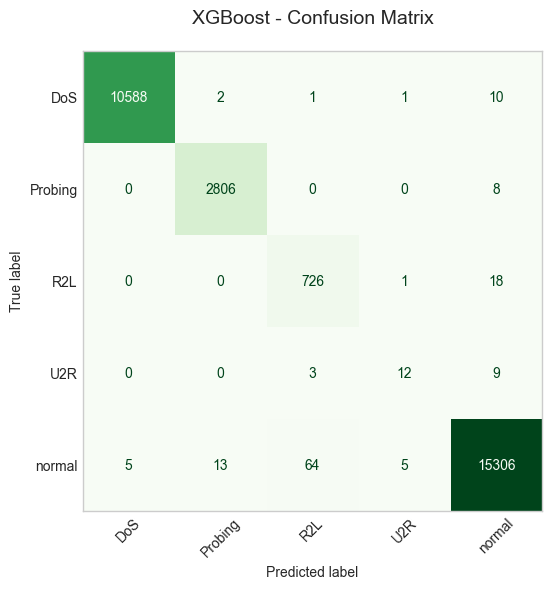


Weighted Average ROC-AUC: 0.999959


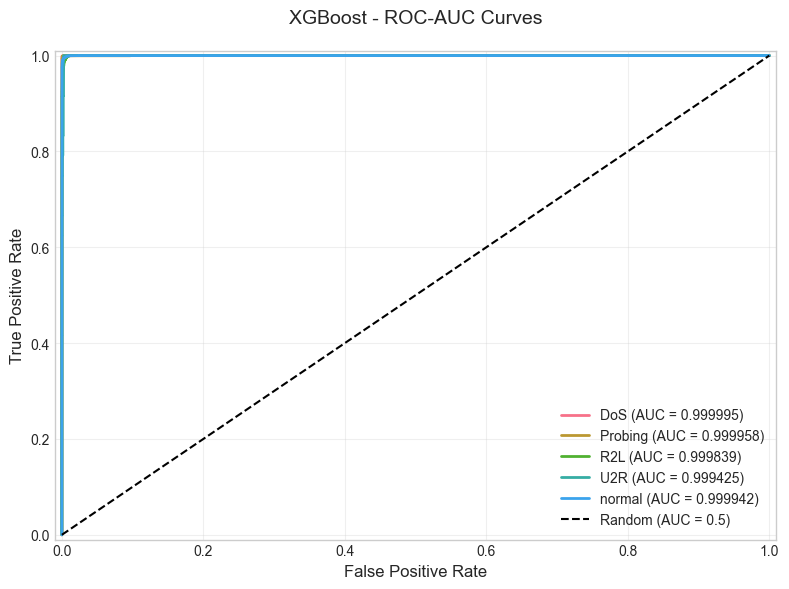

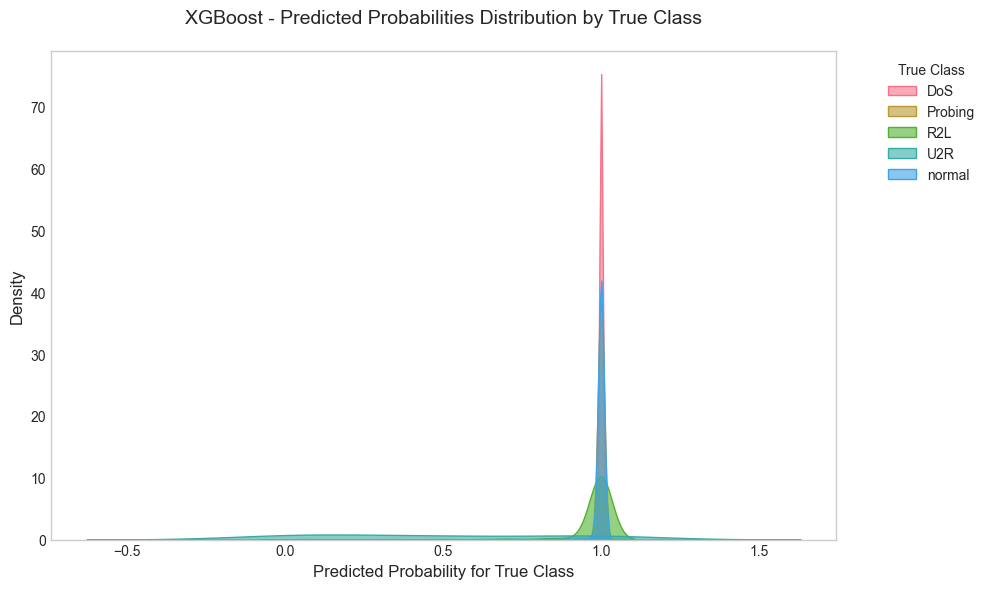

In [16]:
# Evaluation
evaluator = utils.ClassificationEvaluator(
    y_true=y_test_enc,
    y_pred=y_pred_enc,
    y_proba=y_proba,
    label_encoder=label_encoder
)

evaluator.plot_confusion_matrix(title="XGBoost - Confusion Matrix")
evaluator.plot_roc_curves(title="XGBoost - ROC-AUC Curves")
evaluator.plot_probability_distribution(title="XGBoost - Predicted Probabilities Distribution by True Class")

# Hyperparameter Tuning

In [17]:
# Konstanta
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26
N_TRIALS = 10

# Feature selector
feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

# Fungsi objective untuk tuning LightGBM
def manual_objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'objective': 'multiclass',
        'num_class': NUM_CLASSES,
        'metric': 'multi_logloss',
        'verbose': -1,
        'random_state': 42
    }

    lgbm_model = LGBMClassifier(**params)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('clf', lgbm_model)
    ])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    losses = []

    for train_idx, valid_idx in skf.split(X_train, y_train_enc):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_enc[train_idx], y_train_enc[valid_idx]
        sw_tr = sample_weights[train_idx]

        pipeline.fit(X_tr, y_tr, clf__sample_weight=sw_tr)
        y_pred_proba = pipeline.predict_proba(X_val)
        losses.append(log_loss(y_val, y_pred_proba))

    return np.mean(losses)

# Manual loop dengan progress bar
study = optuna.create_study(direction='minimize')
for _ in tqdm(range(N_TRIALS), desc="Optuna Trials"):
    study.optimize(manual_objective, n_trials=1, catch=(Exception,))

[I 2025-07-01 12:22:18,763] A new study created in memory with name: no-name-93c2a8e7-c0f7-4a34-a4b0-298e21d22e48
Optuna Trials:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-07-01 12:24:18,501] Trial 0 finished with value: 0.02726089814476218 and parameters: {'boosting_type': 'goss', 'num_leaves': 174, 'max_depth': 11, 'learning_rate': 0.15591776236556287, 'n_estimators': 972, 'min_child_samples': 22, 'min_split_gain': 0.5322713005165614, 'subsample': 0.7234553843736075, 'colsample_bytree': 0.8544907572398611, 'reg_alpha': 2.8110696237938586, 'reg_lambda': 2.1160469551461194}. Best is trial 0 with value: 0.02726089814476218.
Optuna Trials: 100%|██████████| 10/10 [1:16:53<00:00, 461.33s/it]


In [19]:
print("Best trial:")
print("  Value (log loss):", study.best_value)
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (log loss): 0.02533488842778901
  Params:
    boosting_type: goss
    num_leaves: 259
    max_depth: 14
    learning_rate: 0.1131025356000563
    n_estimators: 734
    min_child_samples: 31
    min_split_gain: 0.07280502414912626
    subsample: 0.8910320991611935
    colsample_bytree: 0.5856575910791283
    reg_alpha: 4.20298421164081
    reg_lambda: 2.7218991433855955


# Evaluation

In [24]:
# Training
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26

best_params = {
    'boosting_type': study.best_trial.params['boosting_type'],
    'num_leaves': study.best_trial.params['num_leaves'],
    'max_depth': study.best_trial.params['max_depth'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'n_estimators': study.best_trial.params['n_estimators'],
    'min_child_samples': study.best_trial.params['min_child_samples'],
    'min_split_gain': study.best_trial.params['min_split_gain'],
    'subsample': study.best_trial.params['subsample'],
    'colsample_bytree': study.best_trial.params['colsample_bytree'],
    'reg_alpha': study.best_trial.params['reg_alpha'],
    'reg_lambda': study.best_trial.params['reg_lambda'],
    'objective': 'multiclass',
    'num_class': NUM_CLASSES,
    'metric': 'multi_logloss',
    'verbose': 0,
    'random_state': 42
}

lgbm_model = LGBMClassifier(**best_params)

feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('algo', utils.StratifiedKFoldMulticlass(
        estimator=lgbm_model,
        n_folds=3,
        method='predict_proba',
        random_state=42
    ))
])

pipeline.fit(
    X_train, 
    y_train_enc,
    algo__sample_weight=sample_weights
)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetFeatureEncoder(to_encode=['protocol_type',
                                                                                                   'service',
                                                                                                   'flag',
                                                                                                   'land',
                                                                                                   'logged_in',
                                                                                                   'root_shell',
                                                                                                   'su_attempted',
                                                                                                   'is_host_login',
                                                                                                   'is_guest_login']))]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'logged_in',
                                                   'root_shell', 'su_attempted',
                                                   'is_host_login'...
                                                                    colsample_bytree=0.5856575910791283,
                                                                    learning_rate=0.1131025356000563,
                                                                    max_depth=14,
                                                                    metric='multi_logloss',
                                                                    min_child_samples=31,
                                                                    min_split_gain=0.07280502414912626,
                                                                    n_estimators=734,
                                                                    num_class=5,
                                                                    num_leaves=259,
                                                                    objective='multiclass',
                                                                    random_state=42,
                                                                    reg_alpha=4.20298421164081,
                                                                    reg_lambda=2.7218991433855955,
                                                                    subsample=0.8910320991611935,
                                                                    verbose=0),
                                           n_folds=3, random_state=42))])

In [25]:
# Prediction
y_pred_enc = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.

Classification Report:
              precision    recall  f1-score   support

         DoS   0.999151  0.998491  0.998821     10602
     Probing   0.984907  0.997157  0.990994      2814
         R2L   0.867299  0.982550  0.921334       745
         U2R   0.486486  0.750000  0.590164        24
      normal   0.998099  0.989021  0.993539     15393

    accuracy                       0.992833     29578
   macro avg   0.867188  0.943444  0.898970     29578
weighted avg   0.993511  0.992833  0.993044     29578



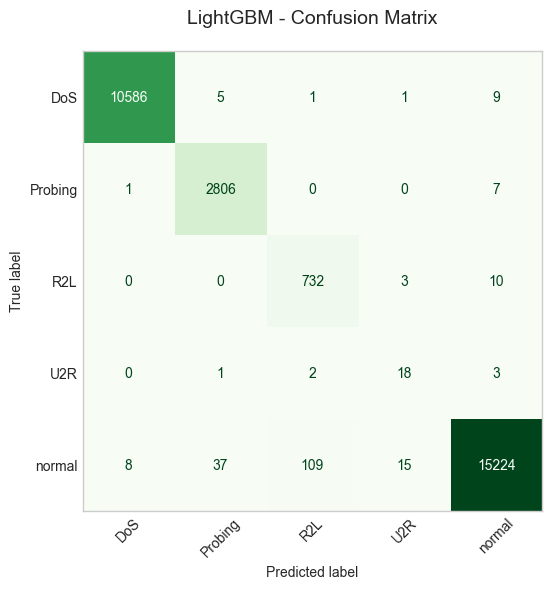


Weighted Average ROC-AUC: 0.999922


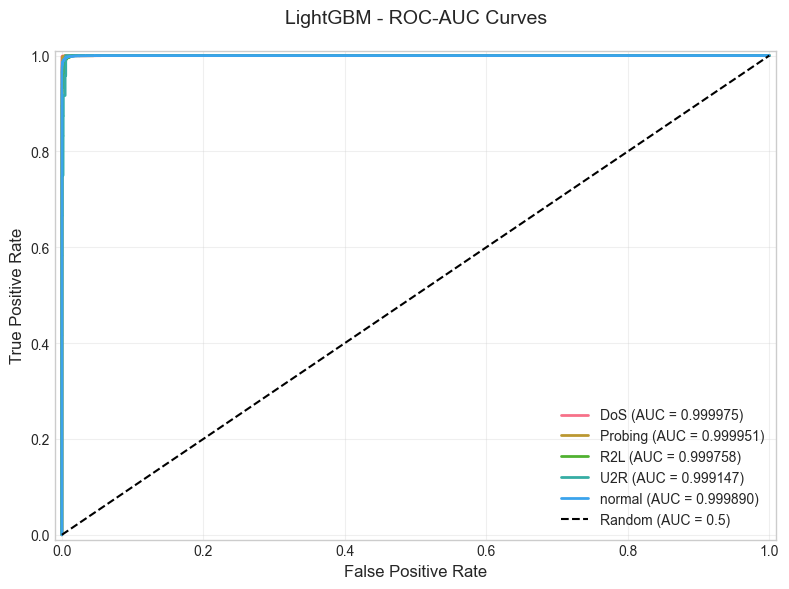

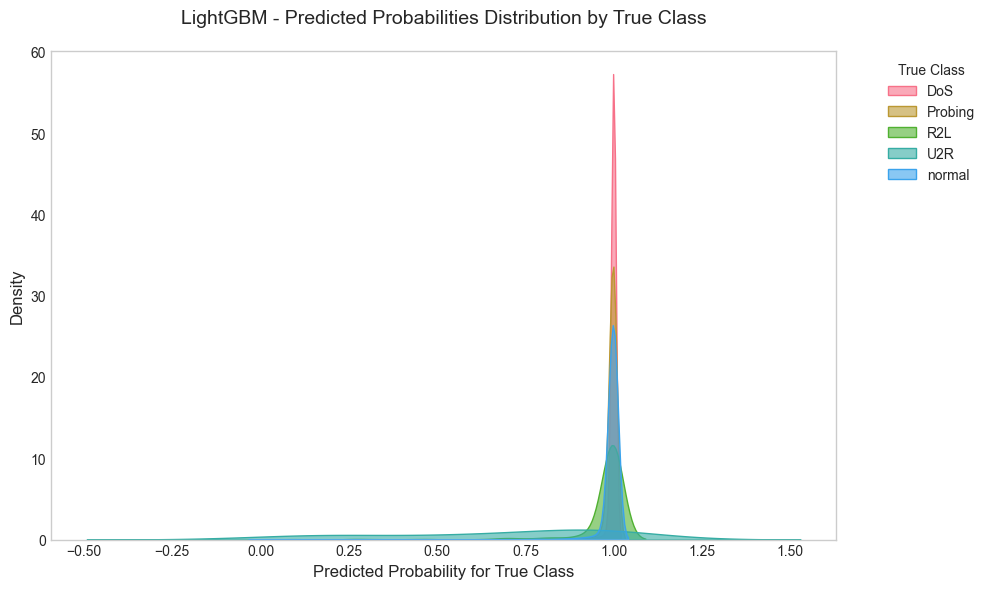

In [26]:
# Evaluation
evaluator = utils.ClassificationEvaluator(
    y_true=y_test_enc,
    y_pred=y_pred_enc,
    y_proba=y_proba,
    label_encoder=label_encoder
)

evaluator.plot_confusion_matrix(title="LightGBM - Confusion Matrix")
evaluator.plot_roc_curves(title="LightGBM - ROC-AUC Curves")
evaluator.plot_probability_distribution(title="LightGBM - Predicted Probabilities Distribution by True Class")

# Save Model

In [31]:
# Simpan pipeline dan model ke file menggunakan pickle
with open("../models/lgbm_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

with open("../models/lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm_model, f)